In [1]:
from psycopg2 import connect as pgconnect
import snowflake.connector
import pandas as pd
import string

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,20)

from IPython.display import SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
recipe_all = pd.read_csv('/Users/xun/Documents/Thesis/recipe_data/recipe_data_processed.csv')
# recipe_all = pd.read_csv('/Users/xun/Documents/Thesis/RSS/recipe_data/recipe_data_processed.csv')
recipe_all.shape # (2060, 15)

(1522, 12)

In [8]:
recipe_all.head()

,publishdate,content_id,title_en,cuisine,difficulty,mealtype,diettype,cooking_method,steps,ingredients,#ingredients,steps_length
0,2017-04-29,R702,Braised chicken with couscous,african,medium,main,non-vegetarian,"marinating,roasting,slow-cooking,steaming",Deglaze with some of the chicken stock. In the...,"['chicken legs', 'chicken stock (divided)', 'c...",18,158
1,2017-11-05,R943,Lamb and quince tagine,african,medium,main,non-vegetarian,NaN,Heat olive oil and butter in a tagine or large...,"['butter', 'cilantro for garnishing', 'ground ...",17,87
2,2018-07-24,R1295,East African-style coconut chicken,african,medium,main,non-vegetarian,sauteing,"Add the onions, garlic, and ginger to the pot ...","['canned crushed tomatoes', 'chicken legs', 'c...",18,220
3,2017-02-02,R574,Moroccan-inspired chickpea stew,african,easy,main,vegetarian,stewing,Add chickpeas to stew and let simmer for appro...,"['apple cider vinegar (optional)', 'black pepp...",29,188
4,2015-06-29,R256,Coleslaw with cranberries,american,easy,others,vegetarian,marinating,Finely chop parsley. Roughly chop cranberries....,"['buttermilk', 'cabbage', 'carrots', 'cranberr...",12,69


In [9]:
recipe_text = recipe_all[['steps']]

In [11]:
recipe_text.head()

,steps
0,Deglaze with some of the chicken stock. In the...
1,Heat olive oil and butter in a tagine or large...
2,"Add the onions, garlic, and ginger to the pot ..."
3,Add chickpeas to stew and let simmer for appro...
4,Finely chop parsley. Roughly chop cranberries....


In [12]:
import spacy
# !python3 -m spacy download en_core_web_md
nlp  = spacy.load('/usr/local/lib/python3.7/site-packages/en_core_web_md/en_core_web_md-2.1.0')

In [13]:
# With spaCy loaded, the documents can be lemmatised.

def keep_token(t):
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    return [ t.lemma_ for t in doc if keep_token(t)]


In [14]:
recipe_text['steps'] = recipe_text['steps'].apply(lambda x: lemmatize_doc(nlp(x)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
pd.set_option('display.max_colwidth', -1)
recipe_text.head()

,steps
0,"[deglaze, chicken, stock, meantime, wash, bell, pepper, remove, seed, cut, strip, rinse, raisin, cold, water, add, cut, bell, pepper, raisin, couscous, remain, chicken, stock, tagine, cover, continue, simmer, approx, min, peel, slice, onion, garlic, remove, chicken, leg, marinade, carefully, drain, heat, oil, tagine, medium, high, heat, add, chicken, leg, garlic, onion, fry, deep, golden, brown, side, place, lid, tagine, let, simmer, approx, min, season, lemon, juice, salt, pepper, Garnish, parsley, serve, directly, tagine, enjoy, wash, dry, chicken, leg, mix, rapeseed, oil, honey, smooth, add, turmeric, cumin, cinnamon, spicy, paprika, salt, pepper, large, bowl, freezer, bag, toss, chicken, leg, marinade, seal, ...]"
1,"[heat, olive, oil, butter, tagine, large, saucepan, sear, meat, onion, approx, min, add, quince, ginger, turmeric, cinnamon, honey, let, simmer, approx, min, stir, occasionally, season, taste, salt, pepper, lime, juice, peel, quarter, core, quince, cut, quince, medium, sized, piece, peel, finely, dice, onion, serve, sesame, seed, yogurt, desire, Garnish, cilantro, pomegranate, seed, enjoy, rice, trim, cut, lamb, medium, sized, piece]"
2,"[add, onion, garlic, ginger, pot, sauté, approx, min, chicken, bone, add, curry, powder, cumin, coriander, garam, masala, turmeric, cinnamon, stick, season, remain, salt, stir, cook, approx, min, fragrant, Debone, chicken, leg, set, bone, aside, later, use, chop, chicken, chunk, season, half, salt, set, aside, bowl, finely, dice, onion, mince, ginger, garlic, remove, end, bell, pepper, cut, inner, core, slice, chunk, peel, potato, cut, chunk, zest, juice, lime, reserve, zest, serve, Set, vegetable, aside, Drain, can, crush, tomato, add, water, drain, tomato, coconut, milk, lime, juice, bell, pepper, potato, pot, stir, cook, cover, approx, min, remove, chicken, bone, add, sear, chicken, ...]"
3,"[add, chickpea, stew, let, simmer, approx, min, serve, add, kale, salt, taste, serve, fresh, herb, lemon, juice, enjoy, large, pot, heat, olive, oil, medium, heat, add, onion, garlic, sear, quickly, low, heat, add, spice, sauté, approx, min, add, sweet, potato, carrot, bell, pepper, fennel, sauté, approx, min, prepare, quinoa, accord, package, instruction, boil, cider, vinegar, lemon, juice, little, white, ring, begin, form, grain, drain, excess, water, set, quinoa, aside, peel, finely, dice, onion, garlic, peel, carrot, sweet, potato, cut, bite, size, piece, Deseed, dice, bell, pepper, remove, leave, core, fennel, chop, rest, small, piece, wash, kale, remove, leave, stem, cut, ...]"
4,"[finely, chop, parsley, roughly, chop, cranberry, cut, onion, carrot, cabbage, thin, strip, large, bowl, thoroughly, mix, parsley, lemon, juice, vinegar, sour, cream, buttermilk, season, taste, salt, pepper, sugar, thoroughly, mix, chop, ingredient, dressing, cover, bowl, plastic, wrap, place, fridge, hour, allow, flavor, blend, enjoy]"


In [16]:
from tqdm import tqdm
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [17]:
vocab = build_vocab(recipe_text.steps.tolist())
import operator
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
sorted_vocab[:10]

100%|██████████| 1522/1522 [00:00<00:00, 61967.74it/s]


[('add', 4080),
 ('approx', 3319),
 ('min', 3109),
 ('heat', 2245),
 ('salt', 1895),
 ('bowl', 1591),
 ('pan', 1555),
 ('pepper', 1405),
 ('oven', 1368),
 ('oil', 1246)]

In [18]:
# Next, the Gensim package can be used to create 
# a dictionary and filter out stop and infrequent words (lemmas)
# !pip3 install gensim
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

# get term(word) dictionary, give each term a unique ID
docs_dict = Dictionary(recipe_text.steps)
# remove words that appear in less than 2 recipes and top 10 frequent words
docs_dict.filter_n_most_frequent(10)
docs_dict.filter_extremes(no_below=2)
docs_dict.compactify()

# print(docs_dict.token2id)

In [19]:
# get TF-IDF Matrix
import numpy as np

docs = recipe_text.steps.tolist()
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [20]:
# docs_vecs is the TF-IDF Matrix, with 1522 rows (docs) and 2111 columns (word terms)
docs_vecs.shape

(1522, 2111)

In [21]:
# Next, we use spaCy to get the 300 dimensional Glove embedding vector 
# for each TF-IDF term.
# nlp('term').vector will get the a word vector of 300 d

# tfidf_emb_vecs matrix has 2111 rows (terms) and 300 columns (Glove vectors).
tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
tfidf_emb_vecs.shape

(2111, 300)

In [22]:
# To get a TF-IDF weighted Glove vector summary of each document, 
# we just need to matrix multiply docs_vecs with tfidf_emb_vecs.

# docs_emb is a matrix with 1522 rows (docs) and 300 columns (Glove vectors as word embeddings)
docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
docs_emb.shape

(1522, 300)

In [23]:
from sklearn.decomposition import PCA

docs_pca = PCA(n_components=8).fit_transform(docs_emb)
docs_pca.shape

(1522, 8)

In [24]:
# t-SNE plot of recipe embedding
from sklearn import manifold

tsne = manifold.TSNE()
viz = tsne.fit_transform(docs_pca)
viz.shape

(1522, 2)

In [40]:
from IPython.display import SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

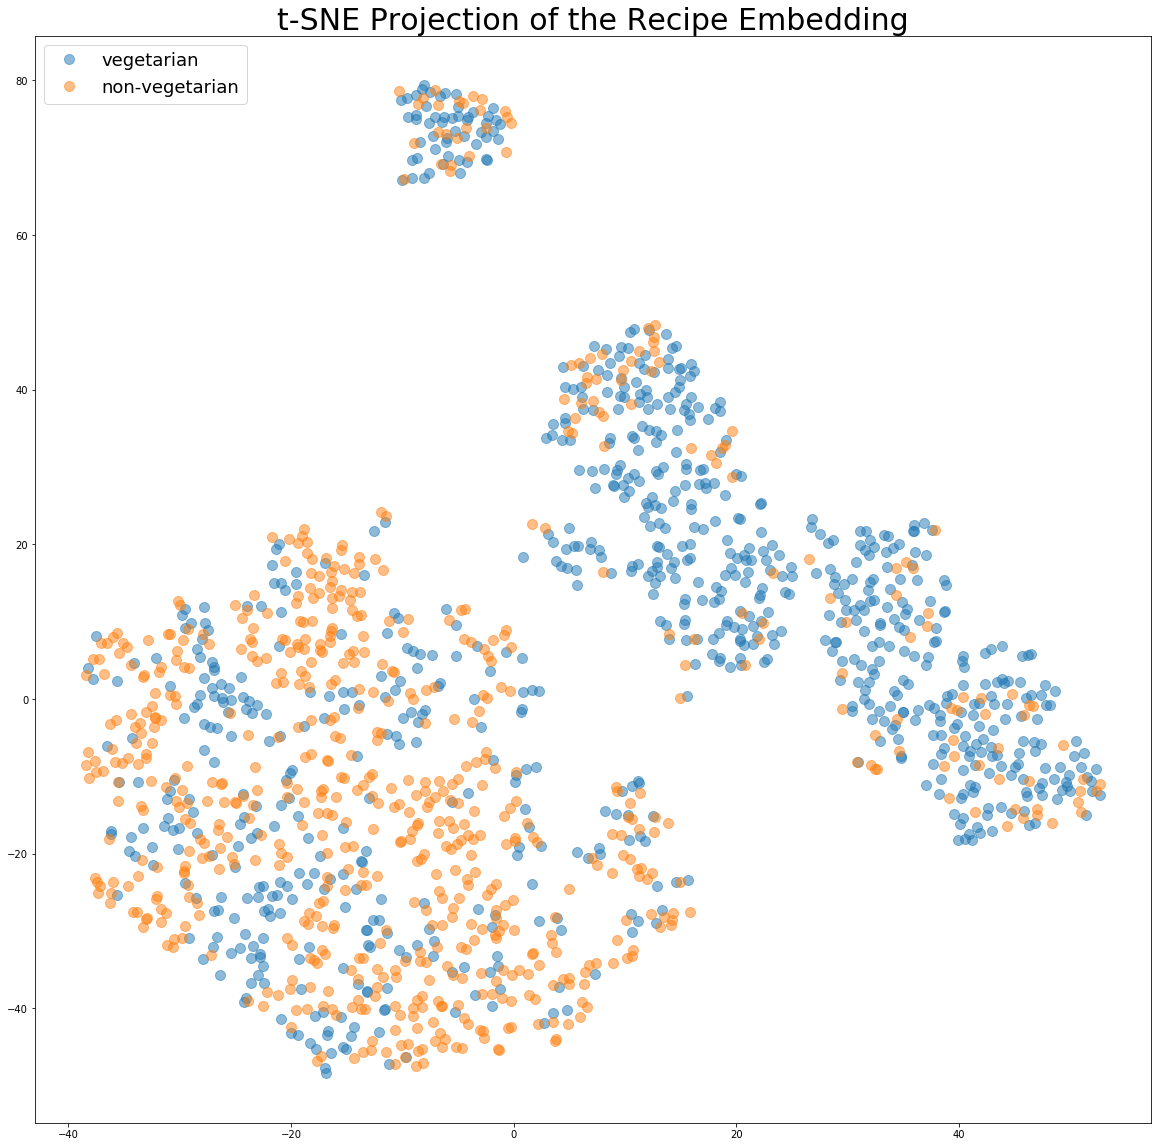

In [41]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,20)
fig, ax = plt.subplots()
ax.margins(0.05) 

zero_indices = np.where(recipe_all.diettype == 'vegetarian')[0]
one_indices = np.where(recipe_all.diettype == 'non-vegetarian')[0]

ax.plot(viz[zero_indices,0], viz[zero_indices,1], marker='o', linestyle='', 
        ms=10, alpha=0.5, label='vegetarian')
ax.plot(viz[one_indices,0], viz[one_indices,1], marker='o', linestyle='', 
        ms=10, alpha=0.5, label='non-vegetarian')
ax.legend()
plt.legend(loc='upper left',fontsize=18)
plt.title('t-SNE Projection of the Recipe Embedding', fontsize=30)
plt.show()

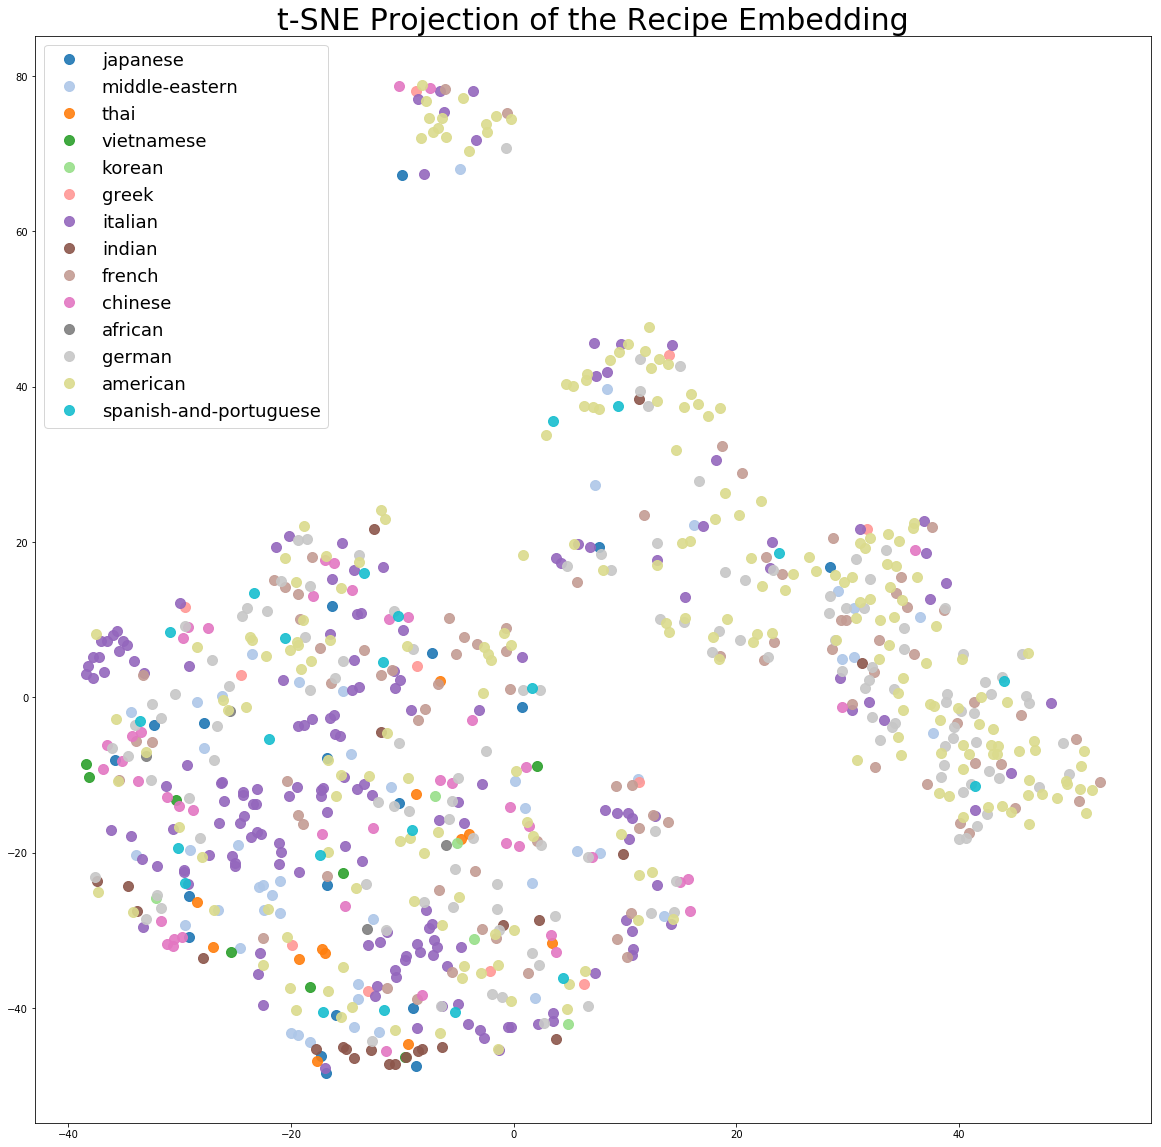

In [42]:
# fig, ax = plt.subplots()
# ax.margins(0.05) 
import matplotlib.colors as colors
import matplotlib.cm as cmx

uniq = list(set(recipe_all.loc[recipe_all['cuisine'] != 'others'].cuisine))


z = range(1,len(uniq))
hot = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

fig, ax = plt.subplots()
ax.margins(0.05) 

for i in range(len(uniq)):
    indx = np.where(recipe_all.cuisine == uniq[i])[0]
#     plt.scatter(viz[indx,0], viz[indx,1], s=15, color=scalarMap.to_rgba(i), label=i)
    ax.plot(viz[indx,0], viz[indx,1], marker='o', linestyle='', ms=10, color=scalarMap.to_rgba(i), 
            alpha=0.9, label=uniq[i])

plt.legend(loc='upper left')
plt.legend(loc='upper left',fontsize=18)
plt.title('t-SNE Projection of the Recipe Embedding', fontsize=30)

plt.show()